In [4]:
import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
device =  torch.device('cuda')

In [5]:
class_name = {
    0: 'down',
    1: 'middle',
    2: 'up'
}
DOWN = 0
MIDDLE = 1
UP = 2

In [6]:
vgg16 = models.vgg16(pretrained=True).to(device)
#print(vgg16.modules)

In [7]:
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier._modules['6'] = nn.Linear(4096, 3)

In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

Copy data from Google Bucket

In [9]:
import csv
import subprocess

with open('/home/jupyter/Pushup-Auto-Counter-CV/pushup_data.csv', newline='') as pushup_data:
    reader = csv.reader(pushup_data, delimiter=' ', quotechar='|')
    for row in reader:
        row = row[0].split(',')
        
        image_path = row[1]
        
        folder = 'train' if row[0] == 'TRAIN' else 'test' if row[0] == 'TEST' else 'validation'
        label = row[2]
        
        bashCommand = f'sudo gsutil cp {image_path} /home/jupyter/Pushup-Auto-Counter-CV/data/{folder}/{label}'
        
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()

print('Data downloaded')


KeyboardInterrupt: 

In [10]:
transform = transforms.Compose([
    transforms.Resize((180, 320)),  
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


trainset = torchvision.datasets.ImageFolder(root='/home/jupyter/Pushup-Auto-Counter-CV/data/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='/home/jupyter/Pushup-Auto-Counter-CV/data/validation', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=8,
                                          shuffle=True)


In [11]:
epochs = 10
vgg16.cuda()
running_loss = 0
for j in range(epochs):
    for i, data in enumerate(trainloader):
        vgg16.train()
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs) # Forward Propogation
        loss = criterion(outputs, labels) # get loss from loss fn
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Update batch loss to later average
        if i % 20 == 19:    # print every 2000 mini-batches
            # Outpul validation loss
            print('[%d, %5d] Loss: %.3f' %
                (j + 1, i + 1, running_loss / 100))
            running_loss = 0
    # print('Accuracy at end of epoch %d: %.3f' % (
    #     epoch, get_accuracy(vgg16, dataloader)))


[1,    20] Loss: 0.218
[1,    40] Loss: 0.190
[2,    20] Loss: 0.248
[2,    40] Loss: 0.156
[3,    20] Loss: 0.207
[3,    40] Loss: 0.131
[4,    20] Loss: 0.192
[4,    40] Loss: 0.117
[5,    20] Loss: 0.157
[5,    40] Loss: 0.114
[6,    20] Loss: 0.155
[6,    40] Loss: 0.111
[7,    20] Loss: 0.146
[7,    40] Loss: 0.097
[8,    20] Loss: 0.140
[8,    40] Loss: 0.088
[9,    20] Loss: 0.129
[9,    40] Loss: 0.089
[10,    20] Loss: 0.126
[10,    40] Loss: 0.087


In [15]:
correct = 0
total = 0
vgg16.cuda()
with torch.no_grad():           # Do not update gradients when evaluating
    for data in valloader: 
        images, labels = data[0].to(device), data[1].to(device) #Put data on CUDA
        vgg16.eval() # Set model to eval mode
        outputs = vgg16(images) # Run forward prop
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        total += labels.size(0) # Add the mini batch size
        correct += (predicted == labels).sum().item() # add the correcrt predictions
print(100 * correct / total)

93.75


In [16]:
import numpy as np

def show_sample(X, y, prediction=-1):
    img = X / 2 + 0.5    
    npimg = img.to('cpu').numpy() # convert back to numpy for plt
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[int(y)], class_name[int(prediction)]))
    else:
        plt.title("Class = %s" % (class_name[int(y)]))
    plt.show()
    # print labels

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


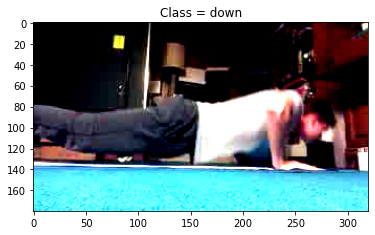

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


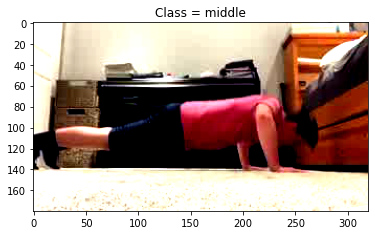

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


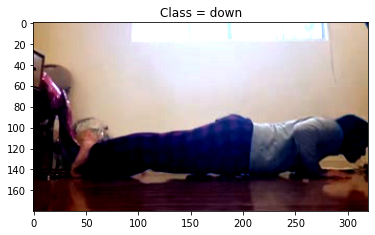

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


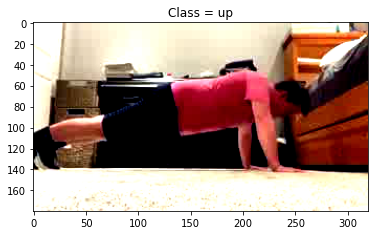

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


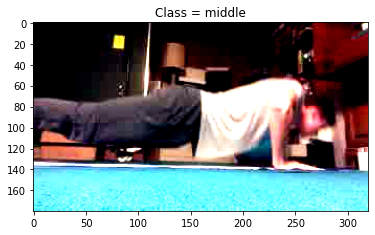

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


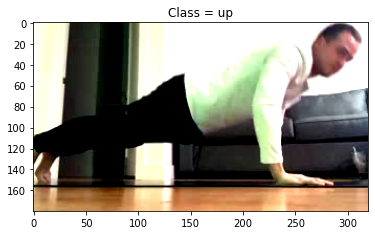

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


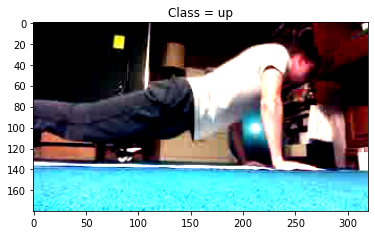

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


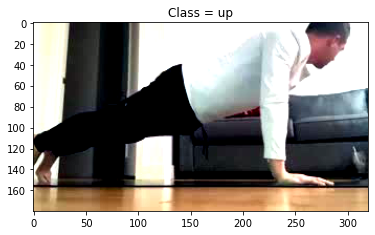

In [17]:
for i, data in enumerate(valloader):
    images, labels = data
    for i in range(len(labels)):
        show_sample(images[i], labels[i])
    break

In [18]:
for param in vgg16.parameters():
    param.requires_grad = True

In [19]:
epochs = 10
vgg16.cuda() # make sure we are on gpu
running_loss = 0
for j in range(epochs):
    for i, data in enumerate(trainloader):
        vgg16.train() # set it to training mode
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() # zero out the gradients
        outputs = vgg16(inputs) # Forward Propogation
        loss = criterion(outputs, labels) # get loss from loss fn
        loss.backward() # back prop
        optimizer.step() # update weights

        running_loss += loss.item() # Update batch loss to later average
        if i % 20 == 19:    # print every 2000 mini-batches
            # Outpul validation loss
            print('[%d, %5d] Loss: %.3f' %
                (j + 1, i + 1, running_loss / 100))
            running_loss = 0
    # print('Accuracy at end of epoch %d: %.3f' % (
    #     epoch, get_accuracy(vgg16, dataloader)))

[1,    20] Loss: 0.081
[1,    40] Loss: 0.075
[2,    20] Loss: 0.097
[2,    40] Loss: 0.050
[3,    20] Loss: 0.069
[3,    40] Loss: 0.041
[4,    20] Loss: 0.056
[4,    40] Loss: 0.052
[5,    20] Loss: 0.045
[5,    40] Loss: 0.039
[6,    20] Loss: 0.040
[6,    40] Loss: 0.039
[7,    20] Loss: 0.029
[7,    40] Loss: 0.021
[8,    20] Loss: 0.027
[8,    40] Loss: 0.018
[9,    20] Loss: 0.026
[9,    40] Loss: 0.010
[10,    20] Loss: 0.038
[10,    40] Loss: 0.014


In [20]:
correct = 0
total = 0
vgg16.cuda()
with torch.no_grad():           # Do not update gradients when evaluating
    for data in valloader: 
        images, labels = data[0].to(device), data[1].to(device) #Put data on CUDA
        vgg16.eval() # Set model to eval mode
        outputs = vgg16(images) # Run forward prop
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        total += labels.size(0) # Add the mini batch size
        correct += (predicted == labels).sum().item() # add the correcrt predictions
print(100 * correct / total)

95.83333333333333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


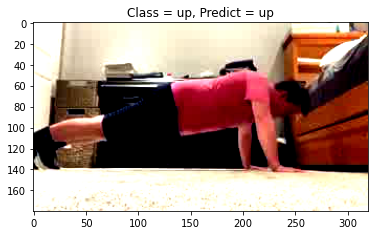

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


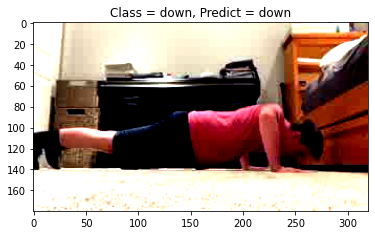

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


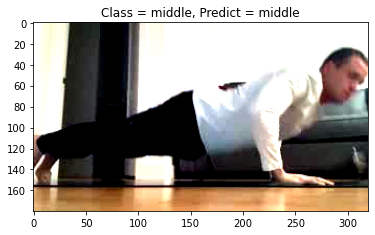

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


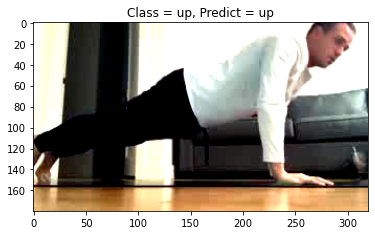

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


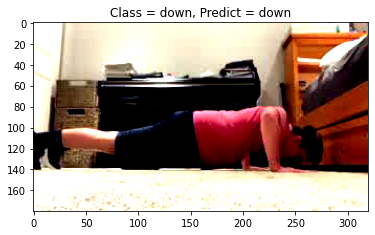

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


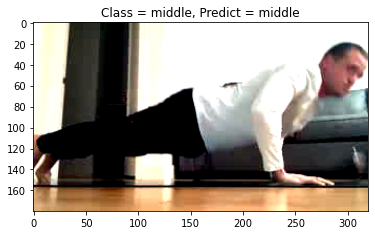

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


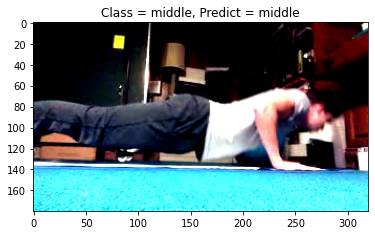

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


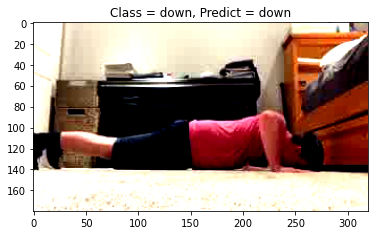

In [21]:
with torch.no_grad():           # Do not update gradients when evaluating
    for i, data in enumerate(valloader):
        images, labels = data[0].to(device), data[1].to(device)
        vgg16.eval() 
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        for i in range(len(labels)):
            show_sample(images[i], labels[i], predicted[i])
        break

In [22]:
import sys

import cv2
print(cv2.__version__)

def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*200))
        cv2.imwrite(pathOut + f'frame-{count}.jpg', image)     # save frame as JPEG file
        count = count + 1
        success,image = vidcap.read()
    print('Finished Extraction')
    return count

4.4.0


In [2]:
path_to_movie = '/home/jupyter/Pushup-Auto-Counter-CV/nick.mov'
path_to_images = '/home/jupyter/Pushup-Auto-Counter-CV/images-extracted-nick/'
count = extractImages(path_to_movie, path_to_images)

Finished Extraction


In [23]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((180, 320)),  
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = transform(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

In [25]:
last = 0
status = {
    0: 'start',
    1: 'going down',
    2: 'down',
    3: 'going up'
}

failed = 0
total = 0

with torch.no_grad(): 
    vgg16.eval()
    for i in range(count):
        image = image_loader(path_to_images + f'frame-{i}.jpg') 
        output = vgg16(image)

        _, predicted = torch.max(output.data, 1) # Get the arg max
        state = int(predicted[0])
        if state == UP:
            if last == 1:
                failed += 1
            if last == 2 or last == 3:
                total += 1
            last = 0
        elif state == MIDDLE:
            if last == 0:
                last = 1
            if last == 2:
                last = 3
        else:
            last = 2
        #print(status[last])
    print(f'Total pushups done: {total}, failed pushups: {failed}')


start
start
going down
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
going down
down
down
down
start
start
going down
down
down
goin up
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
down
down
down
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
start
going down
down
down
goin up
start
going down
down
down
down
goin up
start
start
down
down
down
goin up
start
going down
down
down
down
start
start
going down
down
down
down
goin up
start
going down
down
down
goin up
start
start
going down
down
down
down
goin up
start
start
down
down
down
goin up
start
start
going down
down
down
goin up
start
start